In [1]:
import gzip
from pathlib import Path

In [2]:
import h5py
import numpy as np
from sklearn.metrics import matthews_corrcoef, accuracy_score, roc_auc_score, roc_curve, auc, precision_recall_curve, confusion_matrix
from scipy.stats.stats import pearsonr
from matplotlib import pyplot as plt

In [3]:
#BASE_DIR = Path("/mnt/g/My Drive/CloudVault/Masters/Data")
BASE_DIR = Path("/home/jakob/Cloudvault_new/Data")

# Path of directory to get Graphpart output
GRAPHPART_DIR = BASE_DIR/'NetOGlyc5 data'/'GalNAc data'/'06-partitioning'/'netoglyc4_graphpart_partitions'

# Paths of imported embeddings file
EMBEDDING_FILE = BASE_DIR/'NetOGlyc5 data'/'GalNAc data'/'05-embedding'/'netoglyc4_protein_embeddings_netsurfp_output_glyc_labels_max.h5'

# Path of NetOGlyc 5 output
NETOGLYC5_OUTPUT = BASE_DIR/'NetOGlyc5 data'/'GalNAc data'/'07-benchmarking'/'netoglyc4_data'/'CNNbLSTM_NetOGlyc_NetSurfP'/'2022-01-19-153652'/'epoch_5.h5'

# Maximum sequence length of proteins for test set
#MAX_SEQ_LENGTH = 1022
MAX_SEQ_LENGTH = 34350

IGNORE_MISSING_IDS = True

In [4]:
GRAPHPART_OUTPUT_FILE = GRAPHPART_DIR/'graphpart_output.csv'

In [5]:
clusters = [set(), set(), set()]
with open(GRAPHPART_OUTPUT_FILE, 'r') as f:
    f_iter = iter(f)
    header = next(f_iter).strip().split(',')
    for line in f_iter:
        AC, priority, glycosylated, cluster = line.strip().split(',')
        priority = priority == "True"
        glycosylated = float(glycosylated) > 0
        cluster = int(float(cluster))
        clusters[cluster].add(AC)

testing_ids = clusters[2]

len(testing_ids)

36

In [6]:
with h5py.File(EMBEDDING_FILE, 'r') as file:
    label_identifiers_list = file['identifiers'].asstr()[:].tolist()
    label_sequences_list = file['sequences'].asstr()[:].tolist()
    label_seq_lengths = [len(seq) for seq in label_sequences_list]
    label_gly = file['labels']['gly'][:, :MAX_SEQ_LENGTH, 0]

In [7]:
with h5py.File(NETOGLYC5_OUTPUT, 'r') as file:
    pred_identifiers_list = file['identifiers'].asstr()[:].tolist()
    pred_sequences_list = file['sequences'].asstr()[:].tolist()
    pred_seq_lengths = [len(seq) for seq in pred_sequences_list]
    pred_gly = file['labels']['gly'][:, :MAX_SEQ_LENGTH, 0]

In [8]:
print(f"Maximum sequence length in output: {max(pred_seq_lengths)}")

Maximum sequence length in output: 22152


In [9]:
missing_embedding_identifiers = set(testing_ids) - set(label_identifiers_list)
if len(missing_embedding_identifiers) > 0:
    if not IGNORE_MISSING_IDS:
        raise Exception(f"{len(missing_embedding_identifiers)} test identifiers not found in embeddings: {missing_embedding_identifiers}")

missing_scoring_identifiers = set(testing_ids) - set(pred_identifiers_list)
if len(missing_scoring_identifiers) > 0:
    if not IGNORE_MISSING_IDS:
        raise Exception(f"{len(missing_scoring_identifiers)} test identifiers not found in scores: {missing_scoring_identifiers}")

missing_identifiers = missing_embedding_identifiers | missing_scoring_identifiers
if len(missing_identifiers) > 0:
    print(f"Ignoring following {len(missing_identifiers)} missing test identifiers: {missing_identifiers}")

testing_scores = testing_ids - missing_identifiers

In [10]:
unambiguous_pred = []
unambiguous_labels = []

for identifier in testing_scores:
    label_idx = label_identifiers_list.index(identifier)
    seq_length = min(label_seq_lengths[label_idx], MAX_SEQ_LENGTH)

    labels = label_gly[label_idx, :seq_length]
    site_mask = (labels >= 0)

    pred_idx = pred_identifiers_list.index(identifier)
    pred = pred_gly[pred_idx, :seq_length]
    
    unambiguous_pred.append(pred[site_mask])
    unambiguous_labels.append(labels[site_mask])

unambiguous_pred = np.concatenate(unambiguous_pred)
unambiguous_labels = np.concatenate(unambiguous_labels)

In [11]:
def plot_roc_curve(labels, pred, title="Receiver operating characteristic"):
    fpr, tpr, _ = roc_curve(labels, pred)
    roc_auc = auc(fpr, tpr)

    plt.figure()
    lw = 2
    plt.plot(
        fpr,
        tpr,
        color="darkorange",
        lw=lw,
        label="ROC curve (area = %0.2f)" % roc_auc,
    )
    plt.plot([0, 1], [0, 1], color="navy", lw=lw, linestyle="--")
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel("False Positive Rate")
    plt.ylabel("True Positive Rate")
    plt.title(title)
    plt.legend(loc="lower right")
    plt.show()

def calculate_metrics(unambiguous_labels, unambiguous_pred, all_labels_threshold=0.5, pred_threshold=0.5):
    print(f"% of unambiguous sites glycosylated: {(unambiguous_labels > 0).sum() / len(unambiguous_labels) * 100}")
    print(f"Accuracy for unambiguous sites: {accuracy_score(unambiguous_labels, (unambiguous_pred >= pred_threshold))}")
    print(f"MCC for unambiguous sites: {matthews_corrcoef(unambiguous_labels, (unambiguous_pred >= pred_threshold))}")
    print(f"PCC for unambiguous sites: {pearsonr(unambiguous_pred, unambiguous_labels)}")
    print(f"ROC-AUC for unambiguous sites: {roc_auc_score(unambiguous_labels, unambiguous_pred)}")
    
    tn, fp, fn, tp = confusion_matrix(unambiguous_labels, (unambiguous_pred >= pred_threshold)).ravel()
    sensitivity = tp / (tp+fn)
    specificity = tn / (tn+fp)
    print(f"Sensitivity (TPR) for unambiguous sites: {sensitivity*100:.2f}%")
    print(f"Specificity (TNR) for unambiguous sites: {specificity*100:.2f}%")
    
    plot_roc_curve(unambiguous_labels, unambiguous_pred, "Receiver operating characteristic for unambiguous sites")

NetOGlyc-5.0 predictions for test partition of NetOGlyc-4.0 training dataset (387 sites):

% of unambiguous sites glycosylated: 10.077519379844961
Accuracy for unambiguous sites: 0.2868217054263566
MCC for unambiguous sites: 0.16004925350278282
PCC for unambiguous sites: (0.6518796214784319, 3.443613032840715e-48)
ROC-AUC for unambiguous sites: 0.9747273798997937
Sensitivity (TPR) for unambiguous sites: 100.00%
Specificity (TNR) for unambiguous sites: 20.69%


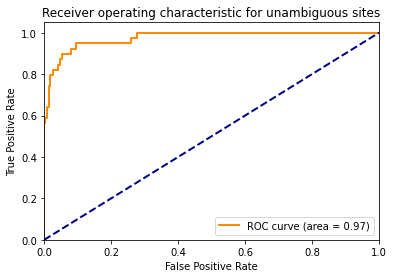

In [12]:
print(f"NetOGlyc-5.0 predictions for test partition of NetOGlyc-4.0 training dataset ({len(unambiguous_labels)} sites):\n")
calculate_metrics(unambiguous_labels, unambiguous_pred)